In [ ]:
# Install time-series libraries
!pip install pandas numpy matplotlib seaborn plotly prophet statsmodels scikit-learn openpyxl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

# Prophet import
try:
    from prophet import Prophet
except Exception as e:
    print("Prophet not available (will fallback to SARIMAX). To enable Prophet install 'prophet' package.")
    Prophet = None

# SARIMAX
import statsmodels.api as sm

# Plot aesthetics
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.figsize'] = [12, 6]


In [ ]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)

df = pd.read_excel(filename)
print("Loaded dataframe shape:", df.shape)
df.head()


Saving Airbnb_Open_Data.xlsx to Airbnb_Open_Data.xlsx
Uploaded file: Airbnb_Open_Data.xlsx
Loaded dataframe shape: (102599, 26)


,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,193.0,10.0,9.0,2021-10-19,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,28.0,30.0,45.0,2022-05-21,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,...,124.0,3.0,0.0,NaT,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,74.0,30.0,270.0,2019-07-05,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,41.0,10.0,9.0,2018-11-19,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [ ]:
# parse many possible date columns
def find_date_column(df):
    # check for explicit date/time column names first
    for name in ['date','booking_date','check_in','checkin','calendar_date', 'last review']:
        if name in df.columns:
            return name

    date_cols = [c for c in df.columns if 'date' in c.lower() or 'checkin' in c.lower() or 'booking' in c.lower() or 'review' in c.lower()]
    if date_cols:
        return date_cols[0]
    return None

date_col = find_date_column(df)
print("Guessed date column (if any):", date_col)

# calendar-style rows with available/price
if {'available','date','listing_id'}.issubset(set(map(str.lower, df.columns))) or {'available','date'}.issubset(set(map(str.lower, df.columns))):
    # try case-insensitive lookup
    cols_lower = {c.lower(): c for c in df.columns}
    date_c = cols_lower.get('date')
    available_c = cols_lower.get('available')
    listing_c = cols_lower.get('listing_id', None)
    cal = df[[date_c, available_c] + ([listing_c] if listing_c else [])].copy()
    cal[date_c] = pd.to_datetime(cal[date_c], errors='coerce')
    # interpret available column
    def booked_flag(x):
        if pd.isna(x): return False
        s = str(x).lower()
        if s in ['t','true','y','yes','1','available','available_true','true_available']: return False
        # if 'f' or 'false' or 'not available' -> booked
        if s in ['f','false','n','no','0','not available','unavailable']: return True
        # fallback: if numeric 0/1
        try:
            v = float(s)
            return v == 0
        except:
            return False
    cal['booked'] = cal[available_c].apply(booked_flag)
    cal['month'] = cal[date_c].dt.to_period('M').dt.to_timestamp()
    demand_monthly = cal.groupby('month')['booked'].sum().rename('bookings').reset_index()
    source = "calendar_booked_flag"
    print("Built monthly demand from calendar-like data; sample:")
    display(demand_monthly.head())

else:
    # per-booking rows (date_col present)
    if date_col is not None and date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        # Attempt to detect whether each row is a booking (e.g., has 'booking_id' or 'price' and 'listing_id' per row)
        possible_booking_id = [c for c in df.columns if 'booking' in c.lower() or 'reservation' in c.lower()]
        if possible_booking_id:
            # assume rows represent bookings
            bk = df[[date_col]].copy()
            bk['month'] = bk[date_col].dt.to_period('M').dt.to_timestamp()
            demand_monthly = bk.groupby('month').size().rename('bookings').reset_index()
            source = "per_booking_rows"
            print("Built monthly demand from per-booking rows (found booking id-like columns).")
            display(demand_monthly.head())
        else:
            # reviews as proxy (if reviews exist or last_review column exists)
            review_cols = [c for c in df.columns if 'review' in c.lower()]
            if 'last review' in df.columns or review_cols:

                if 'comments' in df.columns and date_col in df.columns:
                    # filter rows with comments and dates
                    rev = df[df['comments'].notna()][[date_col, 'comments']].copy()
                    rev[date_col] = pd.to_datetime(rev[date_col], errors='coerce')
                    rev['month'] = rev[date_col].dt.to_period('M').dt.to_timestamp()
                    demand_monthly = rev.groupby('month').size().rename('bookings').reset_index()
                    source = "reviews_rows"
                    print("Built monthly demand from review rows (comments + date).")
                    display(demand_monthly.head())
                else:

                    if 'number of reviews' in df.columns and 'last review' in df.columns:
                        tmp = df[['number of reviews','last review']].copy()
                        tmp['month'] = pd.to_datetime(tmp['last review'], errors='coerce').dt.to_period('M').dt.to_timestamp()
                        tmp['month'] = tmp['month'].fillna(pd.Timestamp.today().to_period('M').to_timestamp())
                        demand_monthly = tmp.groupby('month')['number of reviews'].sum().rename('bookings').reset_index()
                        source = "number_of_reviews_by_last_review_month"
                        print("Built monthly demand proxy using number_of_reviews attributed to last_review month (proxy).")
                        display(demand_monthly.head())
                    else:
                        if {'availability 365','number of reviews'}.issubset(df.columns):

                            avg_night = df['minimum_nights'].replace(0,1).median() if 'minimum_nights' in df.columns else 3
                            df['estimated_booked_days'] = (365 - df['availability 365']).clip(0)
                            total_booked_days = df['estimated_booked_days'].sum()
                            total_est_bookings_per_year = total_booked_days / max(1, avg_night)
                            # Distribute evenly across months as a crude baseline
                            months = pd.date_range(end=pd.Timestamp.today(), periods=12, freq='M')
                            demand_monthly = pd.DataFrame({'month': months.to_period('M').dt.to_timestamp(),
                                                           'bookings': [total_est_bookings_per_year/12]*12})
                            source = "availability_proxy_even_distribution"
                            print("Created an evenly-distributed monthly demand proxy from availability_365 (approx).")
                            display(demand_monthly.head())
                        else:
                            raise ValueError("Could not find calendar, per-booking, review columns, or availability proxies in your dataset. Please upload a calendar or bookings-level file or include review dates.")
    else:
        raise ValueError("No date-like column found. Please make sure your dataset contains date information (calendar/reviews/bookings).")


# Clean demand_monthly
demand_monthly = demand_monthly.dropna(subset=['month']).sort_values('month').reset_index(drop=True)
# ensure monthly continuity
start = demand_monthly['month'].min()
end = demand_monthly['month'].max()
all_months = pd.date_range(start=start, end=end, freq='MS')  # month start
demand_monthly = demand_monthly.set_index('month').reindex(all_months, fill_value=0).rename_axis('month').reset_index()
print("\nFinal monthly demand series prepared (source:", source, ") — sample:")
display(demand_monthly.head(12))

Guessed date column (if any): last review
Built monthly demand proxy using number_of_reviews attributed to last_review month (proxy).


,month,bookings
0,2012-07-01,2.0
1,2012-08-01,4.0
2,2012-09-01,24.0
3,2012-11-01,8.0
4,2012-12-01,28.0



Final monthly demand series prepared (source: number_of_reviews_by_last_review_month ) — sample:


,month,bookings
0,2012-07-01,2.0
1,2012-08-01,4.0
2,2012-09-01,24.0
3,2012-10-01,0.0
4,2012-11-01,8.0
5,2012-12-01,28.0
6,2013-01-01,13.0
7,2013-02-01,0.0
8,2013-03-01,26.0
9,2013-04-01,14.0


from matplotlib import pyplot as plt
_df_0['bookings'].plot(kind='hist', bins=20, title='bookings')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['month']
  ys = series['bookings']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('month')
_ = plt.ylabel('bookings')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['month']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'month'}, axis=1)
              .sort_values('month', ascending=True))
  xs = counted['month']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('month')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_3['bookings'].plot(kind='line', figsize=(8, 4), title='bookings')
plt.gca().spines[['top', 'right']].set_visible(False)

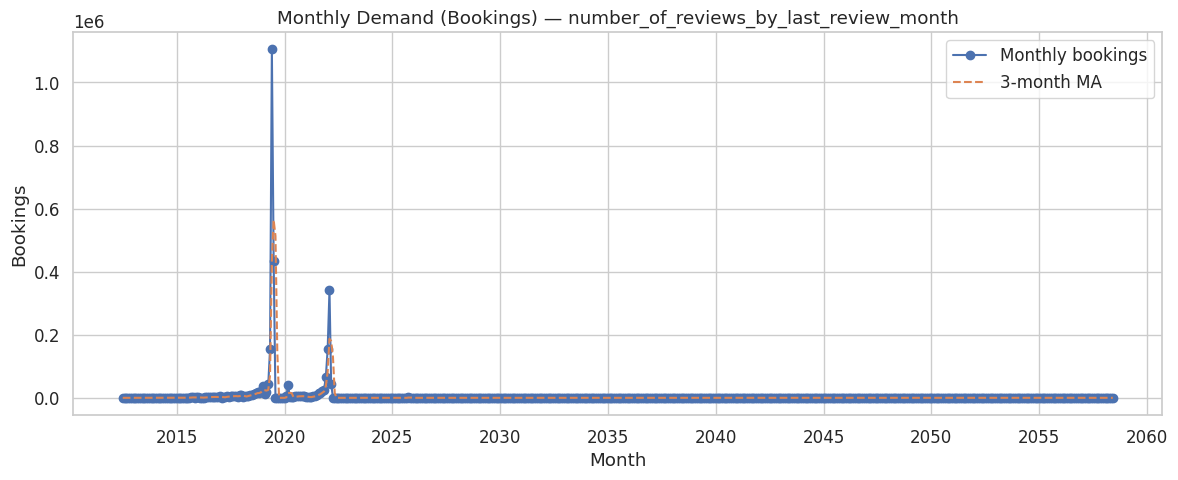

In [ ]:
# Plotly time series
fig = px.line(demand_monthly, x='month', y='bookings', markers=True, title='Monthly Demand (bookings) — derived from ' + source)
fig.update_layout(xaxis_title='Month', yaxis_title='Bookings', template='plotly_white')
fig.show()

# Static plot with moving average
plt.figure(figsize=(12,5))
plt.plot(demand_monthly['month'], demand_monthly['bookings'], marker='o', label='Monthly bookings')
plt.plot(demand_monthly['month'], demand_monthly['bookings'].rolling(3, min_periods=1).mean(), linestyle='--', label='3-month MA')
plt.title('Monthly Demand (Bookings) — ' + source)
plt.xlabel('Month')
plt.ylabel('Bookings')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Prepare series for modeling
ts = demand_monthly.rename(columns={'month':'ds', 'bookings':'y'})[['ds','y']].copy()
ts['ds'] = pd.to_datetime(ts['ds'])

# train/test split: last 6 months as test
test_months = 6
train = ts.iloc[:-test_months].copy()
test = ts.iloc[-test_months:].copy()

print(f"Train months: {len(train)}, Test months: {len(test)}")
display(train.tail())
display(test)


Train months: 546, Test months: 6


,ds,y
541,2057-08-01,0.0
542,2057-09-01,0.0
543,2057-10-01,0.0
544,2057-11-01,0.0
545,2057-12-01,0.0


,ds,y
546,2058-01-01,0.0
547,2058-02-01,0.0
548,2058-03-01,0.0
549,2058-04-01,0.0
550,2058-05-01,0.0
551,2058-06-01,124.0


from matplotlib import pyplot as plt
test['y'].plot(kind='hist', bins=20, title='y')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['ds']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'ds'}, axis=1)
              .sort_values('ds', ascending=True))
  xs = counted['ds']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test.sort_values('ds', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('ds')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['y']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'y'}, axis=1)
              .sort_values('y', ascending=True))
  xs = counted['y']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test.sort_values('y', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('y')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
test['y'].plot(kind='line', figsize=(8, 4), title='y')
plt.gca().spines[['top', 'right']].set_visible(False)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpa8okq6qa/yjfpjqug.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa8okq6qa/7qtlg86b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98137', 'data', 'file=/tmp/tmpa8okq6qa/yjfpjqug.json', 'init=/tmp/tmpa8okq6qa/7qtlg86b.json', 'output', 'file=/tmp/tmpa8okq6qa/prophet_modelimtj54oo/prophet_model-20251007103144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:31:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:31:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet evaluation on test set: {'RMSE': 12404.729114065904, 'MAE': 8797.108801026838, 'MAPE%': np.float64(41662201125683.87)}


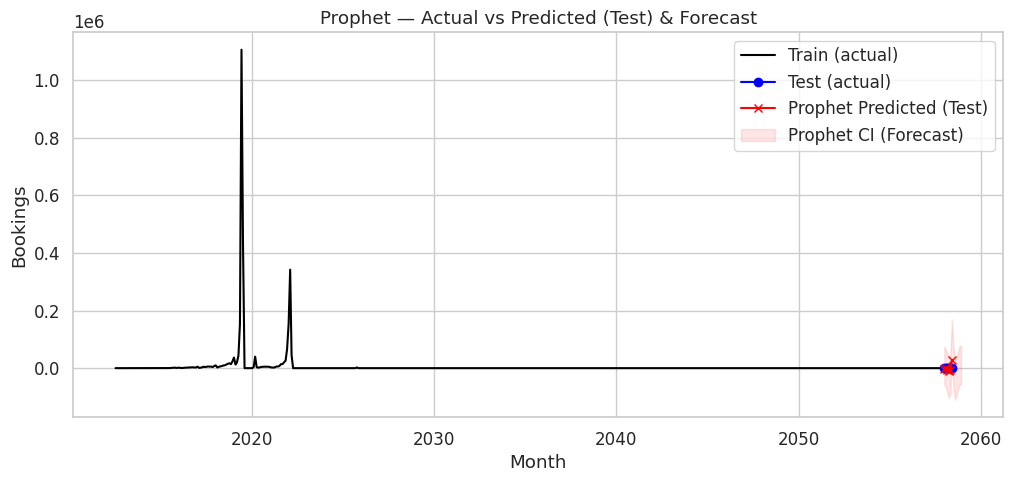

In [ ]:
def eval_metrics(true, pred):
    rmse = sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / (true + 1e-8))) * 100
    return {'RMSE': rmse, 'MAE': mae, 'MAPE%': mape}

if Prophet is not None:
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    # fit
    m.fit(train)

    # Generate future dates for the test set starting from the first test date
    future_test_dates = pd.date_range(start=test['ds'].min(), periods=test_months, freq='MS') # Use 'MS' for Month Start frequency

    # Generate future dates for the forecast period
    future_forecast_dates = m.make_future_dataframe(periods=12, freq='M', include_history=False)['ds'] # Use 'M' for Month End frequency for Prophet's forecast

    # Combine test and forecast dates
    future = pd.concat([pd.DataFrame({'ds': future_test_dates}), pd.DataFrame({'ds': future_forecast_dates})]).drop_duplicates().sort_values('ds')

    forecast = m.predict(future)

    # extract preds for test by filtering the forecast dataframe
    forecast_test = forecast[forecast['ds'].isin(test['ds'])].copy()

    # Ensure test_cleaned has the same dates as forecast_test_cleaned
    test_cleaned = test[test['ds'].isin(forecast_test['ds'])].copy()

    scores_prophet = eval_metrics(test_cleaned['y'].values, forecast_test['yhat'].values)
    print("Prophet evaluation on test set:", scores_prophet)

    # Forecast next 12 months separately
    future_forecast = m.make_future_dataframe(periods=12, freq='M', include_history=False) # Only forecast future dates
    fc = m.predict(future_forecast)
    fc_plot = fc[['ds','yhat','yhat_lower','yhat_upper']].set_index('ds')

    # Prepare data for interactive plot
    plot_data = pd.concat([train[['ds','y']].rename(columns={'y':'Actual Train'}),
                           test[['ds','y']].rename(columns={'y':'Actual Test'}),
                           forecast_test[['ds','yhat']].rename(columns={'yhat':'Prophet Predicted (Test)'}),
                           fc[['ds','yhat']].rename(columns={'yhat':'Prophet Forecast'})])

    plot_data_melted = plot_data.melt(id_vars='ds', value_vars=['Actual Train', 'Actual Test', 'Prophet Predicted (Test)', 'Prophet Forecast'],
                                      var_name='variable', value_name='value')

    fig = px.line(plot_data_melted, x='ds', y='value', color='variable',
                   title='Prophet Forecast vs Actuals', labels={'value':'Bookings', 'ds':'Date'})

    fig.add_scatter(x=fc['ds'], y=fc['yhat_lower'], mode='lines', name='yhat_lower', line=dict(dash='dot', color='green'))
    fig.add_scatter(x=fc['ds'], y=fc['yhat_upper'], mode='lines', name='yhat_upper', line=dict(dash='dot', color='green'))


    fig.update_layout(xaxis_title='Date', yaxis_title='Bookings', template='plotly_white')
    fig.show()


    # Static labeled plot comparing train/test/pred
    plt.figure(figsize=(12,5))
    plt.plot(train['ds'], train['y'], label='Train (actual)', color='black')
    plt.plot(test['ds'], test['y'], label='Test (actual)', color='blue', marker='o')
    plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Prophet Predicted (Test)', color='red', marker='x')
    plt.fill_between(fc_plot.index, fc_plot['yhat_lower'], fc_plot['yhat_upper'], color='red', alpha=0.1, label='Prophet CI (Forecast)')
    plt.title('Prophet — Actual vs Predicted (Test) & Forecast')
    plt.xlabel('Month')
    plt.ylabel('Bookings')
    plt.legend()
    plt.show()
else:
    print("Prophet not installed — skipping Prophet model. SARIMAX will be used instead.")
    scores_prophet = None

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4464      0.038     11.778      0.000       0.372       0.521
ma.L1         -0.9794      0.029    -34.366      0.000      -1.035      -0.924
ar.S.L12      -0.0082      0.259     -0.032      0.975      -0.516       0.500
ma.S.L12      -0.9987      0.104     -9.595      0.000      -1.203      -0.795
sigma2      5.725e+09   9.03e-11   6.34e+19      0.000    5.73e+09    5.73e+09
SARIMAX evaluation on test set: {'RMSE': 510.3640749465585, 'MAE': 464.06407068667585, 'MAPE%': np.float64(3351554780100.9365)}


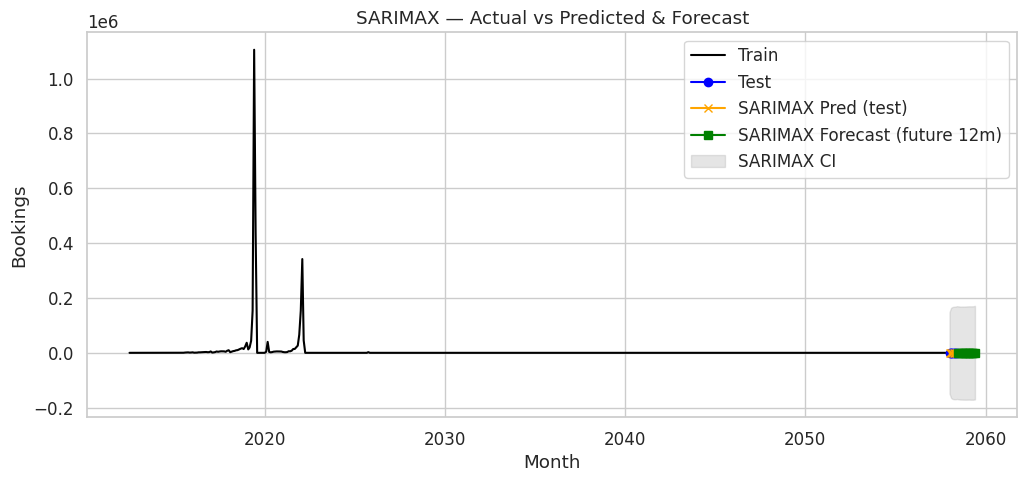

In [ ]:
y_train = train['y'].astype(float).values
y_index = train['ds']

# Fit SARIMAX with seasonal period 12 (monthly)
order = (1,1,1)
seasonal_order = (1,1,1,12)
model = sm.tsa.statespace.SARIMAX(y_train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)
print(res.summary().tables[1])

# Forecast for test months + next 12 months
n_forecast = test_months + 12
pred_res = res.get_forecast(steps=n_forecast)
pred_mean = pred_res.predicted_mean
pred_ci = pred_res.conf_int(alpha=0.05)

# split predicted series into predicted for test and forecast
pred_test = pred_mean[:test_months]
pred_future = pred_mean[test_months:]

# Evaluate on test
scores_sarimax = eval_metrics(test['y'].values, pred_test)
print("SARIMAX evaluation on test set:", scores_sarimax)

# Build dates for predicted values
pred_dates = pd.date_range(start=train['ds'].iloc[-1] + pd.offsets.MonthBegin(1), periods=n_forecast, freq='MS')
pred_df = pd.DataFrame({'ds': pred_dates, 'yhat': pred_mean})
pred_test_df = pred_df.iloc[:test_months]
pred_future_df = pred_df.iloc[test_months:]

# Plot comparison
plt.figure(figsize=(12,5))
plt.plot(train['ds'], train['y'], label='Train', color='black')
plt.plot(test['ds'], test['y'], label='Test', color='blue', marker='o')
plt.plot(pred_test_df['ds'], pred_test_df['yhat'], label='SARIMAX Pred (test)', color='orange', marker='x')
plt.plot(pred_future_df['ds'], pred_future_df['yhat'], label='SARIMAX Forecast (future 12m)', color='green', marker='s')
plt.fill_between(pred_dates, pred_ci[:,0], pred_ci[:,1], color='gray', alpha=0.2, label='SARIMAX CI')
plt.title('SARIMAX — Actual vs Predicted & Forecast')
plt.xlabel('Month')
plt.ylabel('Bookings')
plt.legend()
plt.show()

In [ ]:
print("Model performance summary (on test set):")
if scores_prophet:
    print("Prophet:", scores_prophet)
print("SARIMAX:", scores_sarimax)

# Choose best model by RMSE (simple selection)
best_model_name = None
if scores_prophet:
    if scores_prophet['RMSE'] <= scores_sarimax['RMSE']:
        best_model_name = 'Prophet'
    else:
        best_model_name = 'SARIMAX'
else:
    best_model_name = 'SARIMAX'
print("Selected best model for deployment/forecasting:", best_model_name)

# Prepare final 12-month forecast from chosen model
if best_model_name == 'Prophet' and Prophet is not None:
    # use fc (from Prophet) and take future 12 months
    final_fc = fc[['ds','yhat','yhat_lower','yhat_upper']].set_index('ds').loc[fc['ds'] > train['ds'].max()].reset_index()
    final_fc.rename(columns={'yhat':'forecast','yhat_lower':'lower','yhat_upper':'upper'}, inplace=True)
else:
    final_fc = pred_future_df.copy()
    # approximate intervals from SARIMAX pred_ci for future range
    lower = pred_ci[test_months:, 0] if pred_ci.shape[0] >= test_months+12 else np.full(len(pred_future_df), np.nan)
    upper = pred_ci[test_months:, 1] if pred_ci.shape[0] >= test_months+12 else np.full(len(pred_future_df), np.nan)
    final_fc = final_fc.rename(columns={'yhat':'forecast'})
    final_fc['lower'] = lower
    final_fc['upper'] = upper

final_fc['forecast'] = final_fc['forecast'].clip(lower=0)  # bookings can't be negative
display(final_fc)

# Save forecast to CSV
final_fc.to_csv('monthly_demand_forecast_12m.csv', index=False)
from google.colab import files
files.download('monthly_demand_forecast_12m.csv')
print("Saved monthly_demand_forecast_12m.csv and triggered download.")

Model performance summary (on test set):
Prophet: {'RMSE': 12404.729114065904, 'MAE': 8797.108801026838, 'MAPE%': np.float64(41662201125683.87)}
SARIMAX: {'RMSE': 510.3640749465585, 'MAE': 464.06407068667585, 'MAPE%': np.float64(3351554780100.9365)}
Selected best model for deployment/forecasting: SARIMAX


,ds,forecast,lower,upper
6,2058-07-01,0.000000,-169420.562889,169314.082264
7,2058-08-01,0.000000,-170320.397876,168673.547029
8,2058-09-01,0.000000,-170553.249738,168679.610741
9,2058-10-01,0.000000,-170704.892242,168750.729566
10,2058-11-01,0.000000,-170825.682520,168846.075813
11,2058-12-01,0.000000,-170836.322524,169050.612334
12,2059-01-01,0.000000,-170720.429418,169315.824201
13,2059-02-01,0.000000,-170558.953121,169662.360035
14,2059-03-01,0.000000,-170961.954335,169461.971498
15,2059-04-01,0.000000,-171093.159211,169542.091400


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved monthly_demand_forecast_12m.csv and triggered download.


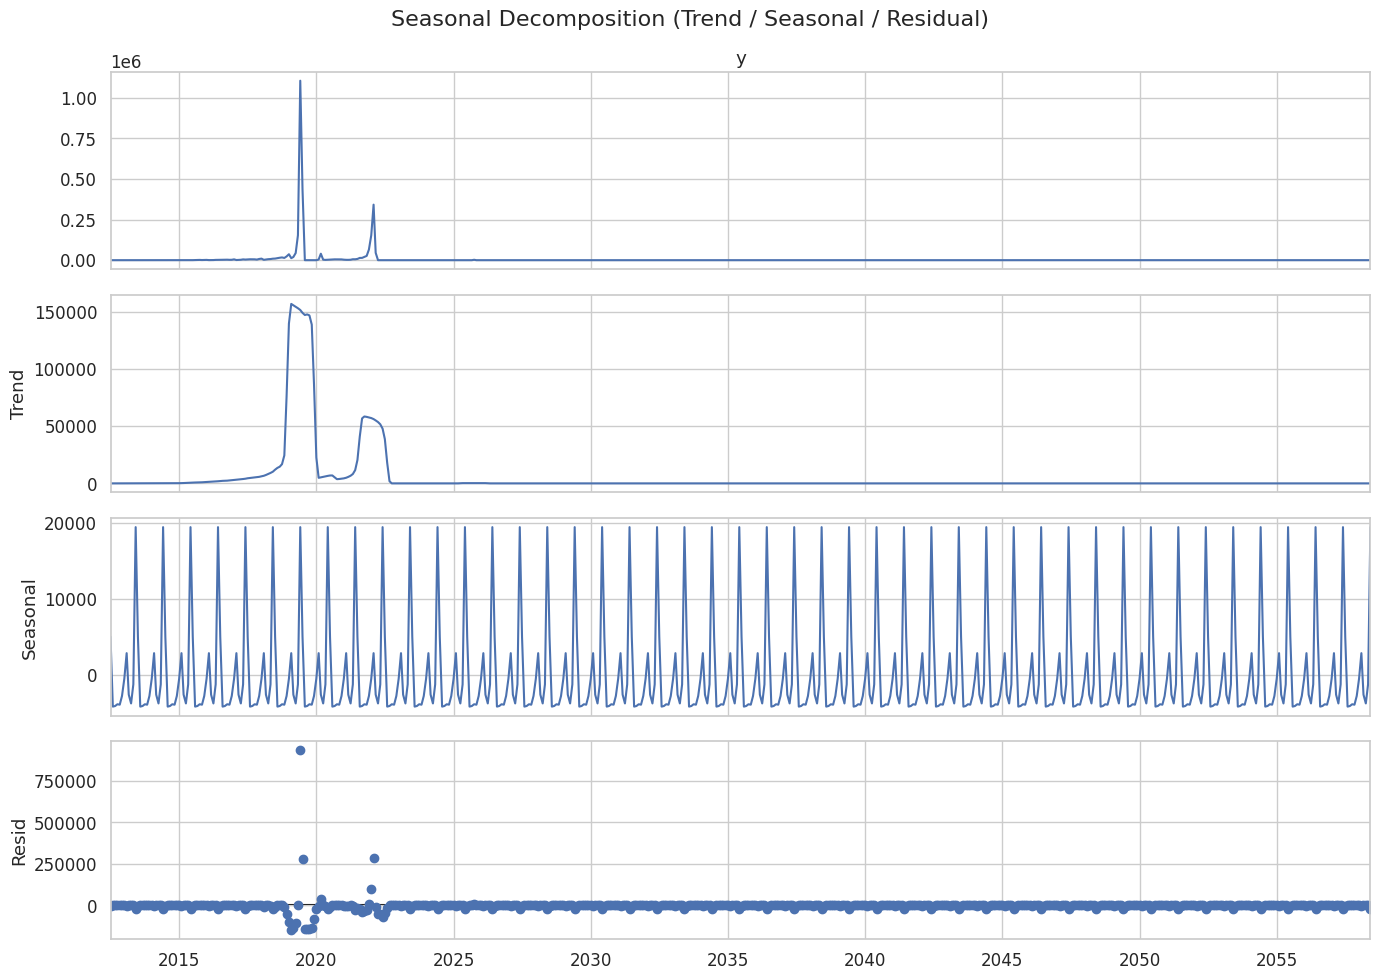

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_indexed = ts.set_index('ds')['y'].asfreq('MS')
decomp = seasonal_decompose(ts_indexed.fillna(0), model='additive', period=12, extrapolate_trend='freq')

fig = decomp.plot()
fig.set_size_inches(14,10)
plt.suptitle('Seasonal Decomposition (Trend / Seasonal / Residual)', fontsize=16)
plt.tight_layout()
plt.show()


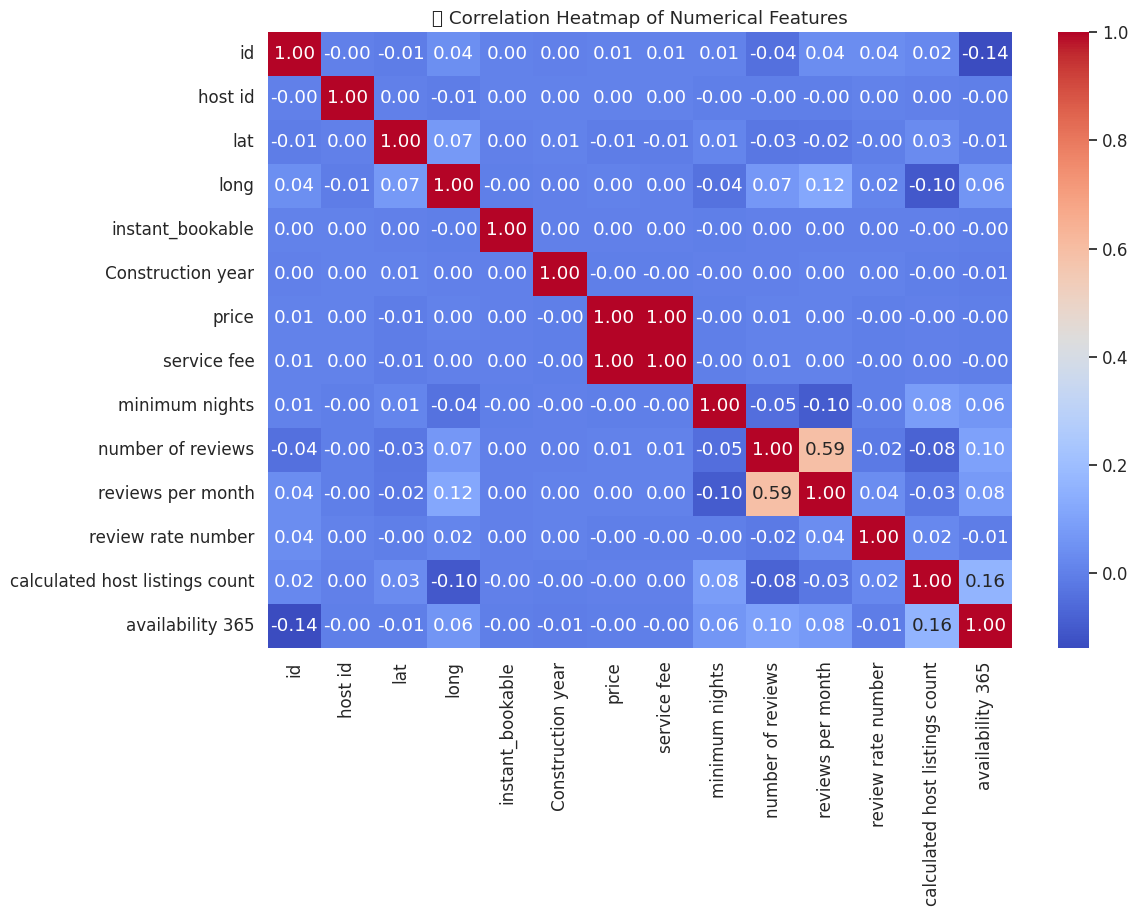

In [28]:
num_cols = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation
corr = num_cols.corr()

# Plot correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

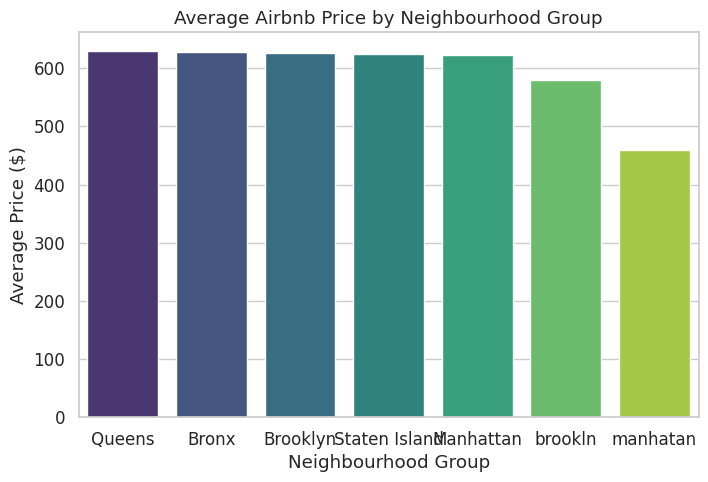

In [33]:
avg_price = df.groupby('neighbourhood group')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=avg_price.index, y=avg_price.values, palette="viridis")
plt.title("Average Airbnb Price by Neighbourhood Group")
plt.xlabel("Neighbourhood Group")
plt.ylabel("Average Price ($)")
plt.show()